In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader,Dataset
import seaborn as sns

In [0]:
def generate_data(data_size,corruption_percentage):
    dims =50
    #np.random.seed(1234)
    y = np.ones(data_size,dtype="long")
    idx = np.random.uniform(size =data_size)>0.5
    y[idx] = 0 
    print("positive_class",sum(y==1),"negative_class",sum(y==0))
    idx1 = ~idx #positive class indices
    idx2 = idx #negative class indices 

    x = np.zeros((data_size,dims))
    x[idx1,0] = np.random.randn(sum(idx1)) # standard normal
    x[idx2,0] = np.random.randn(sum(idx2)) +10 # normal with mean 10 and standard deviation 1

    x[:,1:] = np.random.uniform(-1,1,size=(data_size,dims-1))
    
    # plt.figure(figsize=(8,5))
    # plt.hist(x[idx1,0],density=True,label = str(data_size)+"_1 class")  #positive class histogram 

    # plt.hist(x[idx2,0],density = True, label = str(data_size)+"_0 class")  #negative class histogram
    # plt.xlabel("x1")
    # plt.ylabel("probability density")
    # plt.legend()
    # plt.title("corruption_percentage: "+str(corruption_percentage)+"_Data size: "+str(data_size)+"_histogram")
    
    #corruption_percentage = 0.5
    mask = np.random.uniform(0,1,data_size) < corruption_percentage
    a = np.array(y)
    #print("true",a[mask])
    a[mask] = np.random.randint(0,2,sum(mask))
    #print("randomized",a[mask])
    y = list(a)
    
    return x,y,mask

In [40]:
# np.random.seed(1234)
y = np.ones(100,dtype="long")
idx = np.random.uniform(size =100)>0.5
y[idx] = 0 

print("positive_class",sum(y==1),"negative_class",sum(y==0))

positive_class 57 negative_class 43


In [0]:
idx1 = ~idx #positive class indices
idx2 = idx #negative class indices 

x = np.zeros((100,50))
x[idx1,0] = np.random.randn(sum(idx1)) # standard normal
x[idx2,0] = np.random.randn(sum(idx2)) +10 # normal with mean 10 and standard deviation 1

x[:,1:] = np.random.uniform(-1,1,size=(100,49))

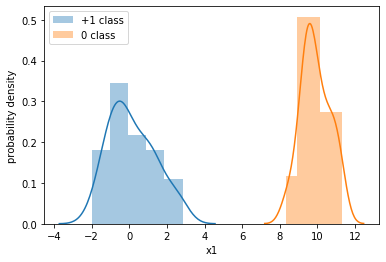

In [42]:
# plt.hist(x[idx1,0],density=True,label = "+1 class")  #positive class histogram 

# plt.hist(x[idx2,0],density = True, label = "0 class")  #negative class histogram
sns.distplot(x[idx1,0], hist=True, label="+1 class")
sns.distplot(x[idx2,0], hist= True, label="0 class")
plt.xlabel("x1")
plt.ylabel("probability density")
plt.legend()

In [24]:
corruption_percentage = 0.1
mask = np.random.uniform(0,1,100) < corruption_percentage
a = np.array(y)
print("true",a[mask])
a[mask] = np.random.randint(0,2,sum(mask))
print("randomized",a[mask])
y = list(a)
# # cifar_trainset_random.targets[:50000] = np.random.randint(low=0,high=9,size=50000)
# #trainloader_random = torch.utils.data.DataLoader(cifar_trainset_random,batch_size=256,shuffle=False,num_workers=2)

true [1 1 0 0 1]
randomized [0 0 0 1 1]


In [25]:
np.unique(y),sum(mask)

(array([0, 1]), 5)

In [0]:
def accuracy( a, b):
    length = a.shape
    #print(a,"dfgfg",length)
    correct = a==b
    return sum(correct)/length


In [0]:
class Synthetic_data(Dataset):
    def __init__(self,x,y):
        super(Synthetic_data,self).__init__()
        self.x = x
        self.y = y
    
    
    def __len__(self):
        return(len(self.y))
    
    
    def __getitem__(self,idx):
        return self.x[idx,:],self.y[idx]
    

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(50,16)
        self.linear2 = nn.Linear(16,2)
#         self.linear3 = nn.Linear(128,64)
#         self.linear4 = nn.Linear(64,2)
    def forward(self,x):
        x =  F.relu(self.linear1(x))
        x =  self.linear2(x)
#         x = F.relu(self.linear3(x))
#         x = self.linear4(x)
        return x

In [0]:
def train(net,data_loader,epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(),lr =0.01)
    
    for epoch in range(epochs):
        running_loss = 0.0
        cnt = 0 
        for i,data in enumerate(data_loader):
            x_input ,targets = data
            #true.append(targets.cpu().numpy())
            optimizer.zero_grad()

            outputs = net(x_input)
            #out.append(outputs.cpu())

            _, predicted = torch.max(outputs, 1)
            #pred.append(predicted.cpu().numpy())
            loss = criterion(outputs,targets)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if cnt % 4 == 3:    # print every 50 mini-batches
                #print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 50))
                running_loss = 0.0
            cnt=cnt+1
    return net,criterion

In [0]:
def evaluate_train(net,dataloader,criterion,mask):
    out = []
    pred = []
    true = []
    for i,data in enumerate(trainloader):
        x_input ,targets = data
        true.append(targets.cpu().numpy())
        
        outputs = net(x_input)
        out.append(outputs.cpu())
        
        _, predicted = torch.max(outputs, 1)
        pred.append(predicted.cpu().numpy())
        
    
    true_targets = np.concatenate(true,axis=0)
    predicted_targets = np.concatenate(pred,axis =0)

    acc_corrupt = accuracy(true_targets[mask],predicted_targets[mask])
    acc_uncorrupt = accuracy(true_targets[~mask],predicted_targets[~mask])
    acc_full = accuracy(true_targets, predicted_targets)
    print("Train accuracy on corrupt data",acc_corrupt)
    print("Train accuracy on un-corrupt data",acc_uncorrupt)
    print("Train accuracy on full data", accuracy(true_targets, predicted_targets))
    
    l= np.where(mask ==True)
    p = np.where(mask == False)

    out = torch.cat(out, dim =0)
    
    print("Train cross entropy loss on corrupt data", criterion(out[l], torch.Tensor(true_targets[l]).type(torch.LongTensor)).item())
    print("Train cross entropy loss on un-corrupt data",criterion(out[p], torch.Tensor(true_targets[p]).type(torch.LongTensor)).item())
    print("Train cross entropy loss on full data",criterion(out, torch.Tensor(true_targets).type(torch.LongTensor)).item())
    print("---"*20)
    loss_full = criterion(out, torch.Tensor(true_targets).type(torch.LongTensor)).item()
    return  acc_full, loss_full
        
        
    

In [0]:
def evaluate_test(net,dataloader,criterion):
    out = []
    pred = []
    true = []
    for i,data in enumerate(trainloader):
        x_input ,targets = data
        true.append(targets.cpu().numpy())
        
        outputs = net(x_input)
        out.append(outputs.cpu())
        
        _, predicted = torch.max(outputs, 1)
        pred.append(predicted.cpu().numpy())
        
    
    true_targets = np.concatenate(true,axis=0)
    predicted_targets = np.concatenate(pred,axis =0)

    
    acc_full = accuracy(true_targets, predicted_targets)
    print("Test accuracy on full data", accuracy(true_targets, predicted_targets))

    out = torch.cat(out, dim =0)
    print("Test cross entropy loss on full data",criterion(out, torch.Tensor(true_targets).type(torch.LongTensor)).item())
    print("---"*20)
    loss_full = criterion(out, torch.Tensor(true_targets).type(torch.LongTensor)).item()
    return  acc_full, loss_full
        

In [32]:
datasizes = [100,500,1000,2000,5000,10000]
corrupt_percent = [0.01,0.1,0.2,0.5]
train_acc=[]
train_ce_loss=[]
test_acc=[]
test_ce_loss=[]
for i in datasizes:
    for j in corrupt_percent:
        
        x,y,mask = generate_data(data_size= i , corruption_percentage= j)
        
        x_test,y_test,mask_test = generate_data(data_size= i , corruption_percentage= 0)
        
        #print(sum(mask))
        
        
        data_set = Synthetic_data(x,y)
        test_set = Synthetic_data(x_test,y_test)
        
        trainloader = DataLoader(data_set,batch_size=20,shuffle=False)
        testloader = DataLoader(test_set,batch_size=20,shuffle=False)
        net = Net().double()
        
        net,criterion = train(net,trainloader,300)
        
        a,b = evaluate_train(net,trainloader,criterion,mask)
        
        c,d = evaluate_test(net , testloader, criterion)
        
        train_acc.append(a)
        train_ce_loss.append(b)
        test_acc.append(c)
        test_ce_loss.append(d)


positive_class 50 negative_class 50
positive_class 52 negative_class 48
Train accuracy on corrupt data [1.]
Train accuracy on un-corrupt data [1.]
Train accuracy on full data [1.]
Train cross entropy loss on corrupt data 0.6543385457874766
Train cross entropy loss on un-corrupt data 0.019550069218633972
Train cross entropy loss on full data 0.025897953984322392
------------------------------------------------------------
Test accuracy on full data [1.]
Test cross entropy loss on full data 0.025897953984322392
------------------------------------------------------------
positive_class 55 negative_class 45
positive_class 51 negative_class 49
Train accuracy on corrupt data [0.8]
Train accuracy on un-corrupt data [1.]
Train accuracy on full data [0.99]
Train cross entropy loss on corrupt data 0.37378510073390875
Train cross entropy loss on un-corrupt data 0.030667548888206973
Train cross entropy loss on full data 0.04782342648049207
---------------------------------------------------------

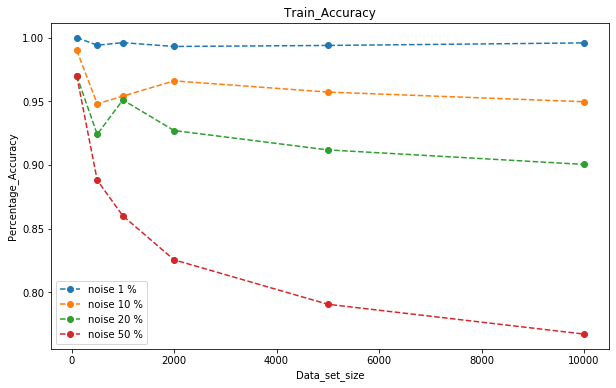

In [33]:
plt.figure(figsize=(10,6))
plt.plot(datasizes,[train_acc[0],train_acc[4],train_acc[8],train_acc[12],train_acc[16],train_acc[20]],"o--",label="noise 1 %")
plt.plot(datasizes,[train_acc[1],train_acc[5],train_acc[9],train_acc[13],train_acc[17],train_acc[21]],"o--",label="noise 10 %")
plt.plot(datasizes,[train_acc[2],train_acc[6],train_acc[10],train_acc[14],train_acc[18],train_acc[22]],"o--",label="noise 20 %")
plt.plot(datasizes,[train_acc[3],train_acc[7],train_acc[11],train_acc[15],train_acc[19],train_acc[23]],"o--",label="noise 50 %")
plt.legend()
plt.xlabel("Data_set_size")
plt.ylabel("Percentage_Accuracy")
plt.title("Train_Accuracy")
plt.show()

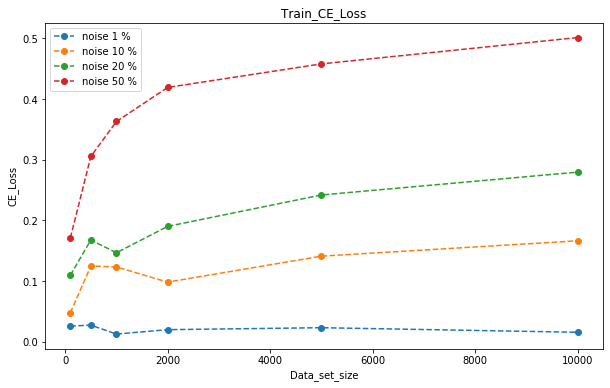

In [34]:
plt.figure(figsize=(10,6))
plt.plot(datasizes,[train_ce_loss[0],train_ce_loss[4],train_ce_loss[8],train_ce_loss[12],train_ce_loss[16],train_ce_loss[20]],"o--",label="noise 1 %")
plt.plot(datasizes,[train_ce_loss[1],train_ce_loss[5],train_ce_loss[9],train_ce_loss[13],train_ce_loss[17],train_ce_loss[21]],"o--",label="noise 10 %")
plt.plot(datasizes,[train_ce_loss[2],train_ce_loss[6],train_ce_loss[10],train_ce_loss[14],train_ce_loss[18],train_ce_loss[22]],"o--",label="noise 20 %")
plt.plot(datasizes,[train_ce_loss[3],train_ce_loss[7],train_ce_loss[11],train_ce_loss[15],train_ce_loss[19],train_ce_loss[23]],"o--",label="noise 50 %")
plt.legend()
plt.xlabel("Data_set_size")
plt.ylabel("CE_Loss")
plt.title("Train_CE_Loss")
plt.show()

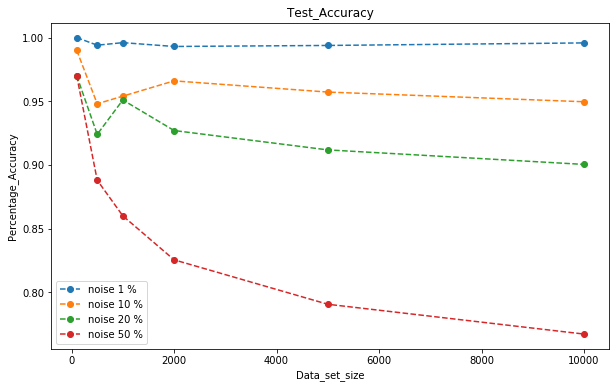

In [35]:
plt.figure(figsize=(10,6))
plt.plot(datasizes,[test_acc[0],test_acc[4],test_acc[8],test_acc[12],test_acc[16],test_acc[20]],"o--",label="noise 1 %")
plt.plot(datasizes,[test_acc[1],test_acc[5],test_acc[9],test_acc[13],test_acc[17],test_acc[21]],"o--",label="noise 10 %")
plt.plot(datasizes,[test_acc[2],test_acc[6],test_acc[10],test_acc[14],test_acc[18],test_acc[22]],"o--",label="noise 20 %")
plt.plot(datasizes,[test_acc[3],test_acc[7],test_acc[11],test_acc[15],test_acc[19],test_acc[23]],"o--",label="noise 50 %")
plt.legend()
plt.xlabel("Data_set_size")
plt.ylabel("Percentage_Accuracy")
plt.title("Test_Accuracy")
plt.show()

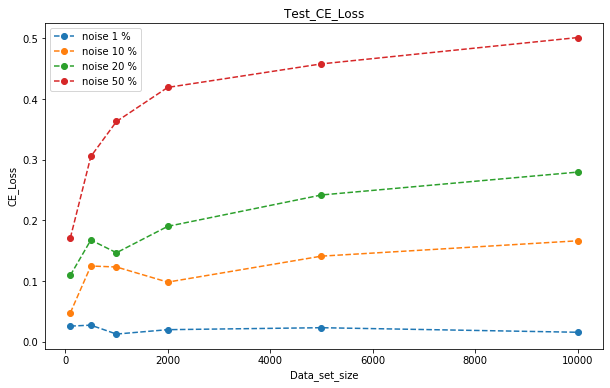

In [36]:
plt.figure(figsize=(10,6))
plt.plot(datasizes,[test_ce_loss[0],test_ce_loss[4],test_ce_loss[8],test_ce_loss[12],test_ce_loss[16],test_ce_loss[20]],"o--",label="noise 1 %")
plt.plot(datasizes,[test_ce_loss[1],test_ce_loss[5],test_ce_loss[9],test_ce_loss[13],test_ce_loss[17],test_ce_loss[21]],"o--",label="noise 10 %")
plt.plot(datasizes,[test_ce_loss[2],test_ce_loss[6],test_ce_loss[10],test_ce_loss[14],test_ce_loss[18],test_ce_loss[22]],"o--",label="noise 20 %")
plt.plot(datasizes,[test_ce_loss[3],test_ce_loss[7],test_ce_loss[11],test_ce_loss[15],test_ce_loss[19],test_ce_loss[23]],"o--",label="noise 50 %")
plt.legend()
plt.xlabel("Data_set_size")
plt.ylabel("CE_Loss")
plt.title("Test_CE_Loss")
plt.show()